In [3]:
import numpy as np
import pandas as pd
import math
import random
import re

import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns

# Import required for random matrix generation
import scipy.stats as stats
import scipy.sparse as sparse
from docplex.cp.utils_visu import display

from qiskit import *

# QP specific imports
from qiskit_optimization import QuadraticProgram
from qiskit_optimization.converters import QuadraticProgramToQubo, LinearInequalityToPenalty

In [4]:
import string
labels = string.ascii_uppercase + string.ascii_lowercase   #string.ascii_letters#
from collections import OrderedDict

from matplotlib import pylab as pl

from sklearn.cluster import SpectralClustering
from sklearn import metrics
import markov_clustering as mc

In [5]:
# useful additional packages
import matplotlib.pyplot as plt
import numpy as np
import networkx as nx

from qiskit_aer import Aer
from qiskit.tools.visualization import plot_histogram
from qiskit.circuit.library import TwoLocal
from qiskit_optimization.applications import Maxcut, Tsp 
from qiskit.algorithms.minimum_eigensolvers import SamplingVQE, NumPyMinimumEigensolver
from qiskit.algorithms.optimizers import SPSA
from qiskit.utils import algorithm_globals
from qiskit.primitives import Sampler
from qiskit_optimization.algorithms import MinimumEigenOptimizer

from qiskit.circuit.library import QAOAAnsatz

In [6]:
import numpy as np
from qiskit import QuantumCircuit
from qiskit.quantum_info import PauliList
from qiskit_aer.primitives import Estimator, Sampler

from circuit_knitting.cutting import (
    partition_problem,
    generate_cutting_experiments,
    reconstruct_expectation_values,
)

from circuit_knitting.cutting.instructions import CutWire
from circuit_knitting.cutting import cut_wires, expand_observables
from circuit_knitting_toolbox.circuit_cutting.wire_cutting import cut_circuit_wires

/var/folders/64/rp2jr10901n6vdvhsbn1fz7c0000gn/T/ipykernel_37158/2386799517.py:14: DeprecationWarning: The package namespace circuit_knitting_toolbox is deprecated and will be removed no sooner than Circuit Knitting Toolbox 0.4.0. Use namespace circuit_knitting instead.
  from circuit_knitting_toolbox.circuit_cutting.wire_cutting import cut_circuit_wires
/var/folders/64/rp2jr10901n6vdvhsbn1fz7c0000gn/T/ipykernel_37158/2386799517.py:14: DeprecationWarning: The package namespace circuit_knitting_toolbox.circuit_cutting is deprecated and will be removed no sooner than Circuit Knitting Toolbox 0.4.0. Use namespace circuit_knitting.cutting instead.
  from circuit_knitting_toolbox.circuit_cutting.wire_cutting import cut_circuit_wires


In [7]:
def sprandsym(n, density,seed):
    np.random.seed((seed))
    rvs = stats.poisson(25, loc=10).rvs
    X = sparse.random(n, n, density=density, data_rvs=rvs)
    upper_X = sparse.triu(X) 
    result = upper_X + upper_X.T - sparse.diags(X.diagonal())
    return result

def binarize_sparse_matrix(sparse_matrix):
    # create a copy of the sparse matrix to keep the operation non-destructive
    sparse_copy = sparse_matrix.copy()
    #sparse_copy=sparse_copy-sparse.diags(sparse_copy.diagonal())
    # find the coordinates of non-zero elements
    non_zero_coords = sparse_copy.nonzero()
    # set those elements to 1
    sparse_copy[non_zero_coords] = 1
    return sparse_copy

def generate_graph_from_matrix(binarized_sparse_mat):
    G = nx.from_scipy_sparse_array(binarized_sparse_mat)
    return G


# create the quadratic program instance and define the variables
def create_qp_from_qmatrix(Q_matrix):
    max_keys = Q_matrix.shape[0]
    qp = QuadraticProgram('QUBO Matrix Optimization')
    x = qp.binary_var_list(name='x', keys=range(1, max_keys + 1))

    linear_vars = {qp.get_variable(i).name: Q_matrix[i, j]
                   for i in range(max_keys) for j in range(max_keys) if i == j}
    quadratic_vars = {(qp.get_variable(i).name, qp.get_variable(j).name): Q_matrix[i, j]
                      for i in range(max_keys) for j in range(max_keys) if i != j}

    qp.minimize(linear=linear_vars, quadratic=quadratic_vars)
    return qp
    #print(self.qp.prettyprint())


def create_qaoa_ansatz(qp):
    #self.create_qp_from_qmatrix()
    h_qubo, offset = qp.to_ising()
    #print(h_qubo)
    qaoa_ansatz = QAOAAnsatz(cost_operator=h_qubo, reps=1, )
    qaoa_ansatz.entanglement = 'linear'
    params = len(qaoa_ansatz.parameters)
    theta_range = np.linspace(0, np.pi, params)
    qaoa_qc = qaoa_ansatz.bind_parameters(theta_range)
    decomposed_qaoa_ansatz = qaoa_qc.decompose().decompose().decompose().decompose()
    return h_qubo, offset,decomposed_qaoa_ansatz


In [8]:
def get_subgraph_properties1(G):
    cnt=0
    subgraphs = (G.subgraph(c) for c in nx.connected_components(G))
    subgraph_prop = {}
    prop = []
    max_size = []
    max_subgraph_nodes = ''
    for s in subgraphs:
        #print(s.nodes())
        n = tuple(s.nodes())
        subgraph_prop[n] = nx.adjacency_matrix(s).todense()
        #print(s.size())
        #print(f'Subgraph {cnt}:: Num of Edges: {s.size()},  Nodes : {s.nodes()}  ')
        cnt+=1
        max_size.append(len(s.nodes()))
        if len(s.nodes)== np.max(max_size):
            max_subgraph_nodes = s.nodes()
        
        
    #print(max_subgraph_nodes)
    return cnt, np.max(max_size), subgraph_prop, max_subgraph_nodes



In [201]:
matrix_sizes =  [10] 
matrix_densities = [0.151]#,0.07,0.1,0.2,0.25,0.27] #[0.20,0.30,0.40,0.50,0.60,0.70]
num_of_experiments = 1
random_seeds = [random.randint(300, 1000) for _ in range(num_of_experiments)]
max_cluster_sizes = [3]#,5,7]

n=matrix_sizes[0]
p=matrix_densities[0]
seed = [random.randint(30, 10000) for _ in range(num_of_experiments)][0]

In [202]:
n_qubits = 3

In [203]:
M=sprandsym(n,p,seed)
M=binarize_sparse_matrix(M)
q=generate_graph_from_matrix(M)
qnum_sub_graphs, largest_subgraph_size, qsubgraph_prop, max_subgraph_nodes = get_subgraph_properties1(q)

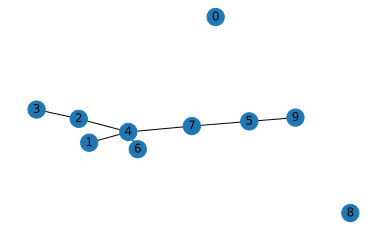

In [204]:
plt.figure(figsize=(5,3))
pos = nx.spring_layout(q, seed=3113794652)
nx.draw(q,pos, with_labels=True )

In [205]:
data = qsubgraph_prop[tuple(max_subgraph_nodes)]
q1=nx.from_numpy_array(data)
node_lbl = dict(zip(list(q1.nodes), list(max_subgraph_nodes)))
nx.set_node_attributes(q1, values=node_lbl, name='labels')

In [206]:
max_subgraph_size = len(max_subgraph_nodes)
max_subgraph_size

8

In [207]:
num_subcircuits = int(np.ceil(max_subgraph_size/n_qubits))
num_subcircuits

3

In [208]:
data = np.array(data)
data

array([[0., 0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 1., 1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0.],
       [1., 1., 0., 1., 0., 1., 1., 0.],
       [0., 0., 0., 0., 0., 0., 1., 1.],
       [0., 0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 1., 1., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0.]])

In [209]:
qp = create_qp_from_qmatrix(data)
print(qp)
h_qubit, offset, qaoa = create_qaoa_ansatz(qp)

minimize 2*x1*x4 + 2*x2*x3 + 2*x2*x4 + 2*x4*x6 + 2*x4*x7 + 2*x5*x7 + 2*x5*x8 + x4 (8 variables, 0 constraints, 'QUBO Matrix Optimization')


In [210]:
qaoa_observable_pat = '[A-Z]+'
observables = PauliList(re.findall(qaoa_observable_pat, str(h_qubit)))
observables

PauliList(['IIIIZIII', 'IIIIIZZI', 'IIIIIIZI', 'IIIIIZII', 'IIIIZIIZ',
           'IIIIIIIZ', 'IIIIZIZI', 'IIZIZIII', 'IIZIIIII', 'IZIIZIII',
           'IZIIIIII', 'IZIZIIII', 'IIIZIIII', 'ZIIZIIII', 'ZIIIIIII'])

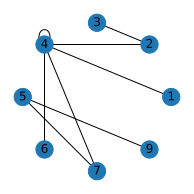

In [211]:
plt.figure(figsize=(2.5,2.5))
pos = nx.circular_layout(q1)
nx.draw(q1, with_labels=True, labels=node_lbl, pos=pos)

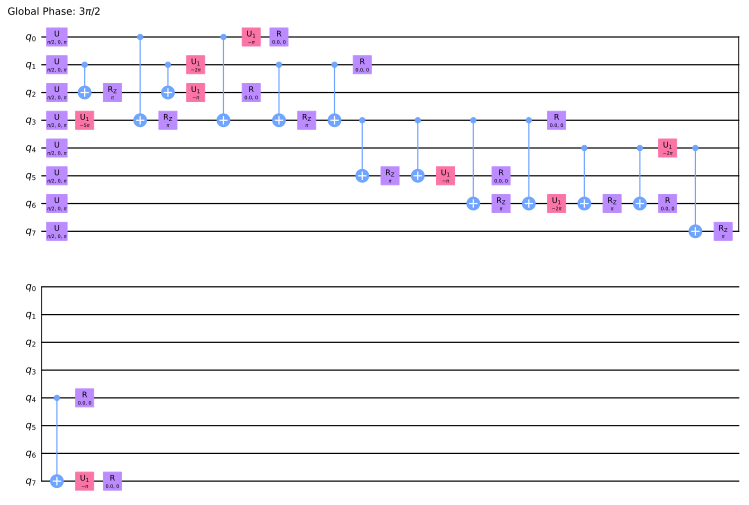

In [212]:
qaoa.draw(scale=0.6)

In [213]:
cuts = cut_circuit_wires(
                        circuit=qaoa,
                        method="automatic",
                        max_subcircuit_width=n_qubits,
                        max_cuts= num_subcircuits+1,
                        num_subcircuits=[num_subcircuits+1]
                    )

Exporting as a LP file to let you check the model that will be solved :  inf <class 'float'>
Version identifier: 22.1.1.0 | 2022-11-28 | 9160aff4d
CPXPARAM_Read_DataCheck                          1
CPXPARAM_TimeLimit                               300
Tried aggregator 6 times.
MIP Presolve eliminated 189 rows and 53 columns.
MIP Presolve modified 49 coefficients.
Aggregator did 181 substitutions.
Reduced MIP has 628 rows, 242 columns, and 1868 nonzeros.
Reduced MIP has 230 binaries, 12 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.02 sec. (6.63 ticks)
Found incumbent of value 3.000000 after 0.02 sec. (8.69 ticks)
Probing fixed 37 vars, tightened 0 bounds.
Probing changed sense of 2 constraints.
Probing time = 0.00 sec. (1.65 ticks)
Tried aggregator 2 times.
MIP Presolve eliminated 129 rows and 67 columns.
MIP Presolve modified 2 coefficients.
Aggregator did 1 substitutions.
Reduced MIP has 498 rows, 174 columns, and 1473 nonzeros.
Reduced MIP has 163 binaries, 11 generals, 0 SOS

In [214]:
cuts.keys()

dict_keys(['max_subcircuit_width', 'subcircuits', 'complete_path_map', 'num_cuts', 'counter', 'classical_cost'])

#### find the a_subs automatically based cuts.complete_path_map

In [215]:
qubit_sc_idx = {}
all_sc_idx = []
for k, i in cuts['complete_path_map'].items():
    #print(k.index)
    qubit_sc_idx.setdefault(k.index,[])
    for m in range(len(i)):
        #print((f"suncircuit idx= :{i[m]['subcircuit_idx']}"))
        qubit_sc_idx[k.index].append(i[m]['subcircuit_idx'])
        if i[m]['subcircuit_idx'] not in all_sc_idx:
            all_sc_idx.append(i[m]['subcircuit_idx'])
        
qubit_sc_idx  ## {'qubit no : sub circuit to which it belongs to '}

/var/folders/64/rp2jr10901n6vdvhsbn1fz7c0000gn/T/ipykernel_37158/2319111569.py:5: DeprecationWarning: 'Bit.index' is deprecated since Qiskit Terra 0.17 and will be removed in a future release. Bits may be in more than one register. Use 'QuantumCircuit.find_bit' to find all the containing registers within a circuit, and the index of the bit within the circuit.
  qubit_sc_idx.setdefault(k.index,[])
/var/folders/64/rp2jr10901n6vdvhsbn1fz7c0000gn/T/ipykernel_37158/2319111569.py:8: DeprecationWarning: 'Bit.index' is deprecated since Qiskit Terra 0.17 and will be removed in a future release. Bits may be in more than one register. Use 'QuantumCircuit.find_bit' to find all the containing registers within a circuit, and the index of the bit within the circuit.
  qubit_sc_idx[k.index].append(i[m]['subcircuit_idx'])


{0: [2], 1: [0, 2], 2: [0], 3: [2, 1], 4: [3], 5: [1], 6: [1, 3], 7: [3]}

In [216]:
all_sc_idx

[2, 0, 1, 3]

In [217]:
sc_idx = set(all_sc_idx)

In [218]:
sc_idx_ = {}
for s in all_sc_idx:
        sc_idx_.setdefault(s,[])
        #print(s)
        for k, v in qubit_sc_idx.items():
            for j in v:
               # print(j)
                if s == j:
                    sc_idx_[s].append(k)
sc_idx_

## {'subgraph idx : qubit belonging to the subgraph'}


#find the qubits present in multiple sub-circuits
# apply cut wire on the qubits - where exactly?

{2: [0, 1, 3], 0: [1, 2], 1: [3, 5, 6], 3: [4, 6, 7]}

In [219]:
qubit_sc_idx #= {0: [0, 1], 1: [0], 2: [2], 3: [1, 2], 4: [1]}

{0: [2], 1: [0, 2], 2: [0], 3: [2, 1], 4: [3], 5: [1], 6: [1, 3], 7: [3]}

In [220]:
cut_pos = {}
for k, v in qubit_sc_idx.items():
    # v is the set of sub-circuits 'k' qubit appears. 
    # if v longer than 1, there are more sub-circuits the qubit belongs to
    if len(v) > 1:
        cut_pos.setdefault(k,[])
        for l in range(len(v)-1):
            #cut wire position for 'k' qubit - after which sub-circuit should the cut wire be applied
            cut_pos[k].append(v[l])

#cut wire position for 'k' qubit - after which sub-circuit should the cut wire be applied
#eg: cut_pos = {0: [0], 3: [0]} - cut wires to be applied after 0th sub-circuit on qubit 0 and 
# after 0th sub-circuit on 3rd qubit
cut_pos

{1: [0], 3: [2], 6: [1]}

#### 
- create matrix with all elements, set the elements of the columns not in sc_idx_ to '0'
- create qaoa for the entire matrix
- apply cut
- compose the next qaoa - since all mtrices are of same shape, the circuit will be applied on the right qubits

In [221]:
len(qubit_sc_idx)

8

In [222]:
qaoa_d = []
for k, v in sc_idx_.items():
    #print(k)
    print(v)
    d = data.copy()
    for i in qubit_sc_idx.keys():
        if i not in v:
        #    print(d[i])
            d[:,i]=0
            d[i,:]=0
    print(d)
    qaoa_d.append(d)

[0, 1, 3]
[[0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 1. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]]
[1, 2]
[[0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]]
[3, 5, 6]
[[0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 1. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]]
[4, 6, 7]
[[0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0.]]


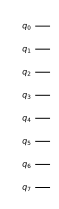

In [255]:
qc = QuantumCircuit(len(qubit_sc_idx.keys()))
qc.draw(scale=0.5)

In [ ]:
#sc_idx_ ----  {0: [0, 1], 1: [0, 3, 4], 2: [2, 3]}

In [ ]:
#find the qubits present in multiple sub-circuits
# apply cut wire on the qubits - where exactly?

In [242]:
cut_pos # qubit idx : subcircuit idx

{1: [0], 3: [2], 6: [1]}

In [246]:
cut_pos.values()

dict_values([[0], [2], [1]])

In [252]:
val = [v for val in cut_pos.values() for v in val]

val

[0, 2, 1]

In [279]:
qc = QuantumCircuit(len(qubit_sc_idx.keys()))

def build_cut_wire_circuit(qc):
    for idx, q in enumerate(qaoa_d):
        qp1 = create_qp_from_qmatrix(q)
        print(qp1)
        h_qubo1, offset1, qaoa1 = create_qaoa_ansatz(qp1)
        print(h_qubo1)
        qc = qc.compose(qaoa1)

        #check if the sub-circuit idx in the cut pos
        #if idx in val:
            #print(val)
        for qubit_idx, subcircuit_idx in cut_pos.items():
            print(subcircuit_idx)
            if idx in subcircuit_idx:
                print('here')
                qc.append(CutWire(), [qubit_idx])
    return qc

qc_0 = build_cut_wire_circuit(qc)

minimize 2*x1*x4 + 2*x2*x4 + x4 (8 variables, 0 constraints, 'QUBO Matrix Optimization')
-1.5 * IIIIZIII
+ 0.5 * IIIIZIIZ
- 0.5 * IIIIIIIZ
+ 0.5 * IIIIZIZI
- 0.5 * IIIIIIZI
[0]
here
[2]
[1]
minimize 2*x2*x3 (8 variables, 0 constraints, 'QUBO Matrix Optimization')
0.5 * IIIIIZZI
- 0.5 * IIIIIIZI
- 0.5 * IIIIIZII
[0]
[2]
[1]
here
minimize 2*x4*x6 + 2*x4*x7 + x4 (8 variables, 0 constraints, 'QUBO Matrix Optimization')
-1.5 * IIIIZIII
+ 0.5 * IIZIZIII
- 0.5 * IIZIIIII
+ 0.5 * IZIIZIII
- 0.5 * IZIIIIII
[0]
[2]
here
[1]
minimize 2*x5*x7 + 2*x5*x8 (8 variables, 0 constraints, 'QUBO Matrix Optimization')
0.5 * IZIZIIII
- 1.0 * IIIZIIII
- 0.5 * IZIIIIII
+ 0.5 * ZIIZIIII
- 0.5 * ZIIIIIII
[0]
[2]
[1]


In [281]:
cut_pos

{1: [0], 3: [2], 6: [1]}

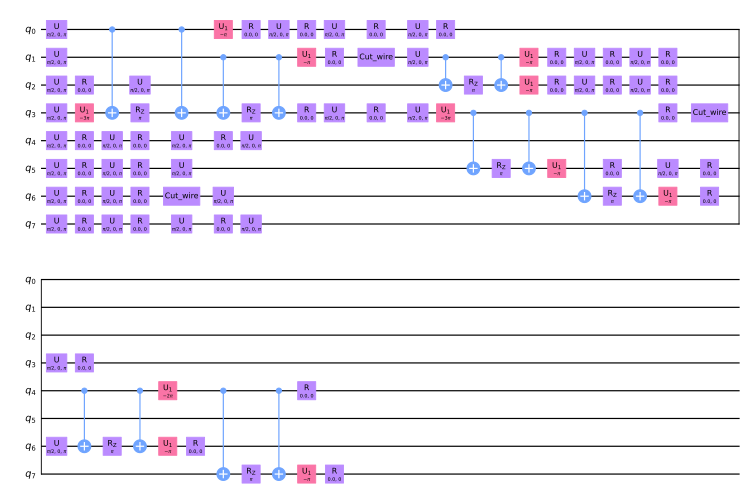

In [280]:
qc_0.draw(scale=0.6)

In [282]:
'''qp1 = create_qp_from_qmatrix(qaoa_d[0])
print(qp1)
h_qubo1, offset1, qaoa1 = create_qaoa_ansatz(qp1)
print(h_qubo1)
qc_0 = qc.compose(qaoa1)
qc_0.append(CutWire(), [0])
 

qp2 = create_qp_from_qmatrix(qaoa_d[1])
print(qp2)
h_qubo2, offset2, qaoa2 = create_qaoa_ansatz(qp2)
print(h_qubo2)
qc_0 = qc_0.compose(qaoa2)
#qc_0.append(CutWire(), [3])

qp3 = create_qp_from_qmatrix(qaoa_d[2])
print(qp3)
h_qubo3, offset3, qaoa3 = create_qaoa_ansatz(qp3)
print(h_qubo3)
qc_0 = qc_0.compose(qaoa3)
qc_0.append(CutWire(), [0])'''

'qp1 = create_qp_from_qmatrix(qaoa_d[0])\nprint(qp1)\nh_qubo1, offset1, qaoa1 = create_qaoa_ansatz(qp1)\nprint(h_qubo1)\nqc_0 = qc.compose(qaoa1)\nqc_0.append(CutWire(), [0])\n \n\nqp2 = create_qp_from_qmatrix(qaoa_d[1])\nprint(qp2)\nh_qubo2, offset2, qaoa2 = create_qaoa_ansatz(qp2)\nprint(h_qubo2)\nqc_0 = qc_0.compose(qaoa2)\n#qc_0.append(CutWire(), [3])\n\nqp3 = create_qp_from_qmatrix(qaoa_d[2])\nprint(qp3)\nh_qubo3, offset3, qaoa3 = create_qaoa_ansatz(qp3)\nprint(h_qubo3)\nqc_0 = qc_0.compose(qaoa3)\nqc_0.append(CutWire(), [0])'

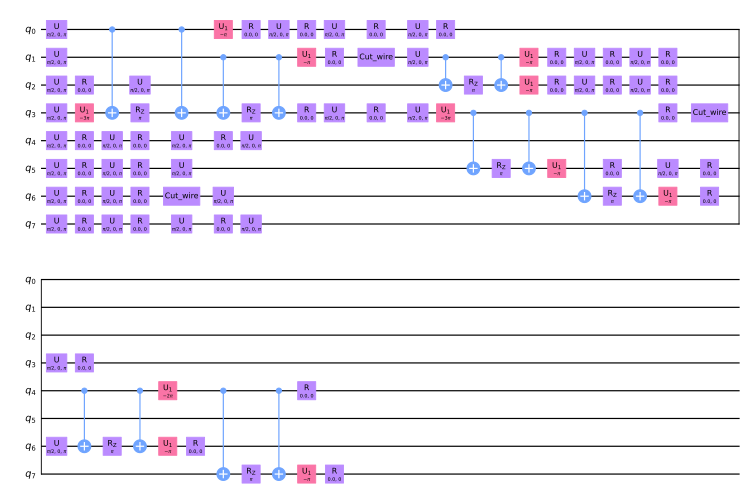

In [283]:
qc_0.draw(scale=0.6)

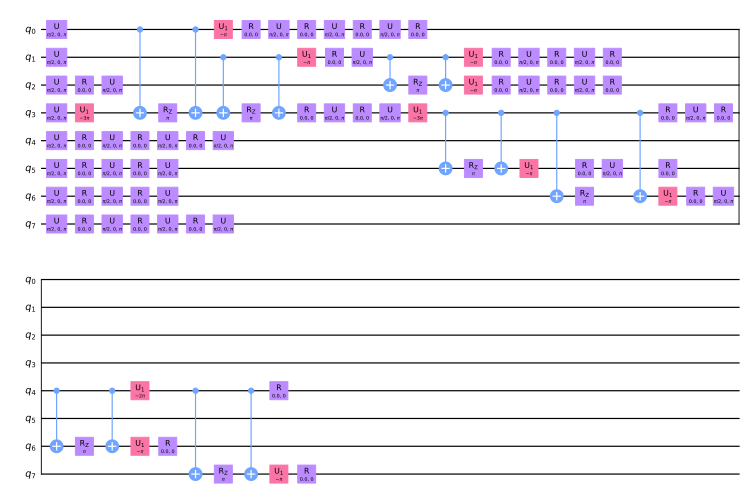

In [284]:
qc_0.decompose("cut_wire").draw("mpl", scale=0.6)

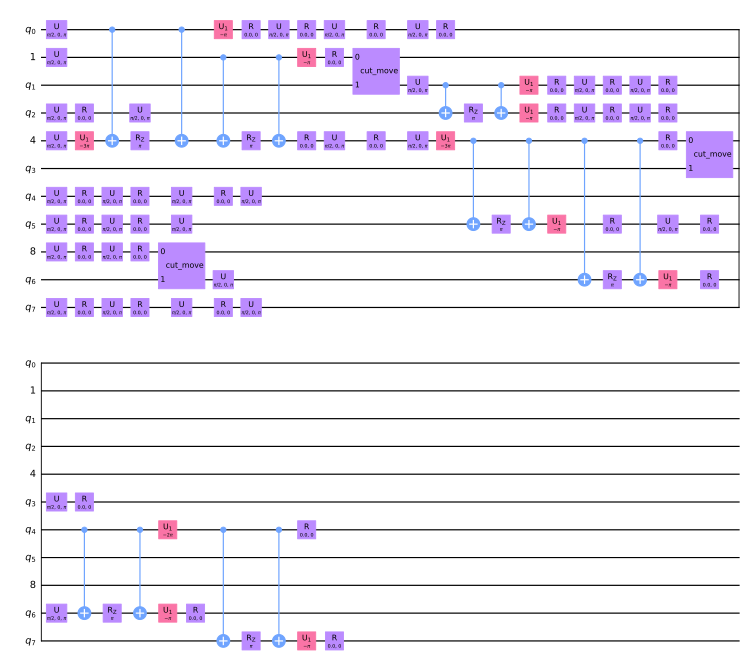

In [285]:
qc_1 = cut_wires(qc_0)
qc_1.draw("mpl", scale=0.6)

In [286]:
observables_1 = expand_observables(observables, qc_0, qc_1)
observables_1

PauliList(['IIIIIZIIIII', 'IIIIIIIZZII', 'IIIIIIIIZII', 'IIIIIIIZIII',
           'IIIIIZIIIIZ', 'IIIIIIIIIIZ', 'IIIIIZIIZII', 'IIIZIZIIIII',
           'IIIZIIIIIII', 'IZIIIZIIIII', 'IZIIIIIIIII', 'IZIIZIIIIII',
           'IIIIZIIIIII', 'ZIIIZIIIIII', 'ZIIIIIIIIII'])

In [287]:
partitioned_problem = partition_problem(circuit=qc_1, observables=observables_1)
subcircuits = partitioned_problem.subcircuits
subobservables = partitioned_problem.subobservables

In [288]:
subobservables

{0: PauliList(['IIIIIII', 'IIIIIII', 'IIIIIII', 'IIIIIII', 'IIIIIIZ',
            'IIIIIIZ', 'IIIIIII', 'IIZIIII', 'IIZIIII', 'IZIIIII',
            'IZIIIII', 'IZIZIII', 'IIIZIII', 'ZIIZIII', 'ZIIIIII']),
 1: PauliList(['II', 'ZZ', 'IZ', 'ZI', 'II', 'II', 'IZ', 'II', 'II', 'II',
            'II', 'II', 'II', 'II', 'II']),
 2: PauliList(['Z', 'I', 'I', 'I', 'Z', 'I', 'Z', 'Z', 'I', 'Z', 'I', 'I',
            'I', 'I', 'I']),
 3: PauliList(['I', 'I', 'I', 'I', 'I', 'I', 'I', 'I', 'I', 'I', 'I', 'I',
            'I', 'I', 'I'])}

In [289]:
subexperiments, coefficients = generate_cutting_experiments(
    circuits=subcircuits,
    observables=subobservables,
    num_samples=1,
)

In [290]:
sampler = Sampler(run_options={"shots": 500})
results = {
    label: sampler.run(subexperiment).result()
    for label, subexperiment in subexperiments.items()
}

In [291]:
reconstructed_expvals = reconstruct_expectation_values(
    results,
    coefficients,
    subobservables,
)

ValueError: The num_qpd_bits field must be set in each subexperiment result metadata dictionary.